# MINE implemented in GAN

## Import libraries

In [944]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

## Set random seed

In [945]:
def set_rand_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_rand_seed(37)

## Generate 2_D circle data

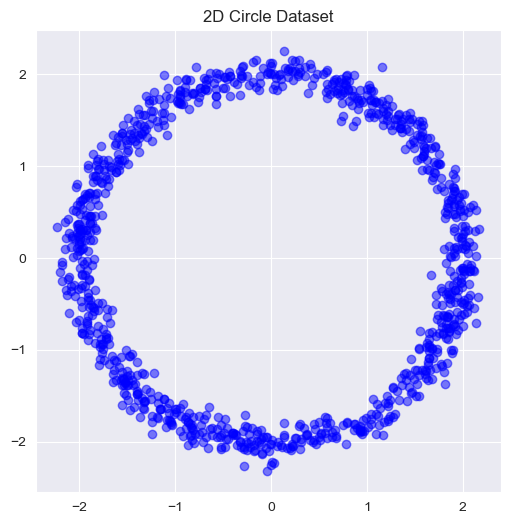

In [946]:
def generate_circle_data(num_samples, radius, noise=0.05):
    angles = np.random.uniform(0, 2 * np.pi, num_samples)
    x = radius * np.cos(angles) + np.random.normal(0, noise, num_samples)
    y = radius * np.sin(angles) + np.random.normal(0, noise, num_samples)
    return np.vstack((x, y)).T

circle_data = generate_circle_data(1000, radius=2, noise=0.1)
plt.figure(figsize=(6, 6))
plt.scatter(circle_data[:, 0], circle_data[:, 1], alpha=0.5, c='blue')
plt.title("2D Circle Dataset")
plt.grid(True)
plt.show()

## Define GAN with MINE

In [947]:
class Generator(nn.Module):
    def __init__(self, input_size=10, output_size=2, hidden_size=128):
        """
        Generator network to map latent space to data space.
        Args:
            input_size: Dimension of the input noise vector.
            output_size: Dimension of the generated data (e.g., 2 for 2D data).
            hidden_size: Number of hidden units in each layer.
        """
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, output_size),
            # nn.Tanh()  # Output is scaled to [-1, 1], later [-2, 2]
        )
        # Initialize the weights and biases of the layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, z):
        """
        Forward pass through the generator.
        Args:
            z: Latent noise vector of shape (batch_size, input_size).
        Returns:
            Generated data of shape (batch_size, output_size).
        """
        return self.network(z)

In [948]:
class Discriminator(nn.Module):
    def __init__(self, input_size=2, hidden_size=128):
        """
        Discriminator network to distinguish real and generated data.
        Args:
            input_size: Dimension of the input data.
            hidden_size: Number of hidden units in each layer.
        """
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()  # transform out to probability [0, 1]
        )
        # Initialize the weights and biases of the layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        """
        Forward pass through the discriminator.
        Args:
            x: Input data of shape (batch_size, input_size).
        Returns:
            Discriminator score (real/fake probability) of shape (batch_size, 1).
        """
        return self.network(x)

In [949]:
class MINE(nn.Module):
    def __init__(self, noise_size=3, data_size=2, hidden_size=128):
        """
        Mutual Information Neural Estimator to calculate MI between input and output.
        Args:
            noise_size: Dimension of the input noise vector.
            data_size: Dimension of the generated data.
            hidden_size: Number of hidden units in each layer.
        """
        super(MINE, self).__init__()
        self.fc1_noise = nn.Linear(noise_size, hidden_size, bias=False)
        self.fc1_data = nn.Linear(data_size, hidden_size, bias=False)
        self.fc1_bias = nn.Parameter(torch.zeros(hidden_size))
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        # Initialize weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, noise, data):
        """
        Forward pass through the MINE network.
        Args:
            noise: Latent noise vector of shape (batch_size, noise_size).
            data: Generated data of shape (batch_size, data_size).
        Returns:
            MI estimation score of shape (batch_size, 1).
        """
        x_noise = self.fc1_noise(noise)
        x_data = self.fc1_data(data)
        x = F.leaky_relu(x_noise + x_data + self.fc1_bias, negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.fc3(x)
        return x

## Define GAN loss and MINE loss

In [950]:
def learn_g(G, D, M, G_optimizer, mi_lambda=0.01, batch_size=16):
    """
    Training step for Generator with Mutual Information (MINE) regularization.

    Args:
        G: Generator network.
        D: Discriminator network.
        M: MINE network.
        G_optimizer: Optimizer for generator network.
        mi_lambda: Weight for the MI regularization term.
        batch_size: Batch size.

    Returns:
        total_g_loss: Combined generator loss (GAN loss + MI regularization).
    """
    # Generate latent noise vectors
    z = torch.randn((batch_size, 10))  # Latent noise
    z_bar = torch.narrow(torch.randn((batch_size, 10)), dim=1, start=0, length=3)  # For marginal distribution

    # Generate fake data
    x_tilde = G(z)

    # GAN loss for generator
    Dx_tilde = D(x_tilde)  # Discriminator's output for fake data

    # MI regularization using MINE
    z_for_mi = torch.narrow(z, dim=1, start=0, length=3)  # Subset of z for MI
    joint_scores = M(z_for_mi, x_tilde)
    marginal_scores = M(z_bar, x_tilde)
    # Compute exponential terms for MI lower bound
    t = torch.mean(joint_scores)
    et = torch.mean(torch.exp(marginal_scores))
    # Compute mutual information
    mi_estimated = torch.mean(t) - torch.log(torch.mean(et)+1e-8)

    # Total generator loss
    g_loss = torch.log(1-Dx_tilde+1e-8).mean() - mi_lambda * mi_estimated

    # Backpropagation and optimization
    G_optimizer.zero_grad()
    g_loss.backward()
    G_optimizer.step()

    return g_loss.item()

In [951]:
def learn_d(batch, G, D, d_optimizer, batch_size=64):
    """
    Training step for the Discriminator with a numerically stable WGAN loss.

    Args:
        batch: Real data samples.
        G: Generator network.
        D: Discriminator network.
        d_optimizer: Optimizer for discriminator network.
        batch_size: Size of the mini-batches.

    Returns:
        d_loss: Discriminator loss value.
    """
    # Generate latent noise and fake data
    z = torch.randn((batch_size, G.network[0].in_features))
    fake_batch = G(z).detach()  # Detach so gradients won't flow to G

    # Discriminator scores for real and fake data
    d_real = D(batch)
    d_fake = D(fake_batch)

    # Numerically stable WGAN loss for discriminator
    d_loss = torch.mean(d_real) - torch.log(torch.mean(1-d_fake)+1e-8)

    # Backpropagation and optimization
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()

In [952]:
def learn_mine(G, M, M_opt, batch_size=64):
    """
    Training step for MINE to estimate mutual information between input and output of Generator.

    Args:
        G: Generator network.
        M: MINE network.
        M_opt: Optimizer for MINE.
        batch_size: Size of the mini-batches.

    Returns:
        mi_loss: Mutual information loss.
        ma_et: Updated moving average of exponential terms.
    """
    # Generate latent noise vectors
    z = torch.randn((batch_size, 10))
    z_bar = torch.narrow(torch.randn((batch_size, 10)), dim=1, start=0, length=3)  # For marginal distribution

    # Generate fake data
    x_tilde = G(z)

    # Forward pass through MINE
    z_for_mi = torch.narrow(z, dim=1, start=0, length=3)  # Subset of z for MI
    joint_scores = M(z_for_mi, x_tilde)
    marginal_scores = M(z_bar, x_tilde)
    # Compute exponential terms for MI lower bound
    t = torch.mean(joint_scores)
    et = torch.mean(torch.exp(marginal_scores))
    # Compute mutual information loss
    mine_loss = -(torch.mean(t) - torch.log(torch.mean(et)+1e-8))

    # Backpropagation and optimization
    M_opt.zero_grad()
    mine_loss.backward()
    M_opt.step()

    return mine_loss.item()

## Training

In [953]:
def adaptive_gradient_clipping(parameters, clipping_factor=0.01, epsilon=1e-8):
    """
    Apply adaptive gradient clipping to stabilize training.
    Args:
        parameters: Model parameters to clip.
        clipping_factor: Scaling factor for the clipping (float).
        epsilon: Small constant to prevent division by zero (float).
    """
    with torch.no_grad():
        for param in parameters:
            if param.grad is not None:
                grad_norm = param.grad.norm()
                param_norm = param.norm()
                if grad_norm > 0 and param_norm > 0:
                    clip_coeff = clipping_factor * param_norm / (grad_norm + epsilon)
                    param.grad *= min(1.0, clip_coeff)

In [954]:
def train(
        G, D, M, g_optimizer, d_optimizer, m_optimizer,
        real_data, epochs=50, batch_size=64,
        mi_lambda=0.01, clipping_factor=0.01
):
    """
    Training loop for GAN with MINE and Adaptive Gradient Clipping.

    Args:
        G: Generator network.
        D: Discriminator network.
        M: MINE network.
        g_optimizer: Optimizer for the Generator.
        d_optimizer: Optimizer for the Discriminator.
        m_optimizer: Optimizer for MINE.
        real_data: Real data samples (torch.Tensor).
        epochs: Number of training epochs.
        batch_size: Size of each mini-batch.
        mi_lambda: Weight for the MI regularization term.
        clipping_factor: Gradient clipping factor for adaptive gradient clipping.

    Returns:
        None
    """
    # Define learning rate schedulers
    g_scheduler = optim.lr_scheduler.CosineAnnealingLR(g_optimizer, T_max=EPOCHS)
    d_scheduler = optim.lr_scheduler.CosineAnnealingLR(d_optimizer, T_max=EPOCHS)
    m_scheduler = optim.lr_scheduler.CosineAnnealingLR(m_optimizer, T_max=EPOCHS)

    for epoch in range(1, epochs + 1):
        np.random.shuffle(real_data)  # Shuffle data at the start of each epoch
        iter_num = len(real_data) // batch_size  # Number of iterations per epoch

        d_loss_arr, g_loss_arr, mi_loss_arr = [], [], []

        for i in tqdm(range(iter_num)):
            # Get the mini-batch
            batch = torch.FloatTensor(
                real_data[i * batch_size: (i + 1) * batch_size]
            )

            if batch.size(0) < batch_size:
                continue

            d_loss = learn_d(batch, G, D, d_optimizer, batch_size)
            adaptive_gradient_clipping(D.parameters(), clipping_factor)
            g_loss = learn_g(G, D, M, g_optimizer, mi_lambda, batch_size)
            mi_loss = learn_mine(G, M, m_optimizer, batch_size)

            d_loss_arr.append(d_loss)
            g_loss_arr.append(g_loss)
            mi_loss_arr.append(-mi_loss)

        # Update schedulers at the end of each epoch
        g_scheduler.step()
        d_scheduler.step()
        m_scheduler.step()

        if epoch % 1 == 0:
            # Print losses for the epoch
            print(
                f"Epoch {epoch}/{epochs} | "
                f"D Loss: {np.mean(d_loss_arr):.4f} | "
                f"G Loss: {np.mean(g_loss_arr):.4f} | "
                f"MI: {np.mean(mi_loss_arr):.4f}"
            )

            # Visualize generated samples
            visualize_generated_data(G, epoch, real_data=circle_data)

In [955]:
def visualize_generated_data(G, epoch, real_data):
    """
    Visualize generated data alongside the original circle data.
    Args:
        G: Generator network.
        epoch: Current epoch number.
        real_data: Real data points (original circle).
    """
    # Generate data from the generator
    z_test = torch.randn((2000, G.network[0].in_features))
    generated_data = G(z_test).detach().numpy()

    plt.figure(figsize=(6, 6))
    plt.title(f"Generated Samples - Epoch {epoch}")

    # Plot real data (original circle)
    plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.5, c="blue", s=2, label="Real Data")

    # Plot generated data
    plt.scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.5, c="orange", s=2, label="Generated Data")

    plt.legend()
    plt.grid(True)
    plt.show()

In [956]:
# Set training hyperparameters
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 1e-2
MI_LAMBDA = 0.01

# Check for GPU availability
USE_GPU = torch.cuda.is_available()

# Initialize Generator
generator = Generator(input_size=10, output_size=2, hidden_size=128)
if USE_GPU:
    generator = generator.cuda()

# Initialize Discriminator
discriminator = Discriminator(input_size=2, hidden_size=128)
if USE_GPU:
    discriminator = discriminator.cuda()

# Initialize MINE
mine_net = MINE(noise_size=3, data_size=2, hidden_size=128)
if USE_GPU:
    mine_net = mine_net.cuda()

# Define optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))
m_optimizer = optim.Adam(mine_net.parameters(), lr=LEARNING_RATE)

# Convert real data to tensor
circle_data_tensor = torch.tensor(circle_data, dtype=torch.float32)
if USE_GPU:
    circle_data_tensor = circle_data_tensor.cuda()

100%|██████████| 7/7 [00:00<00:00, 89.31it/s]

Epoch 1/50 | D Loss: 0.1360 | G Loss: 0.0071 | MI: -1.1296


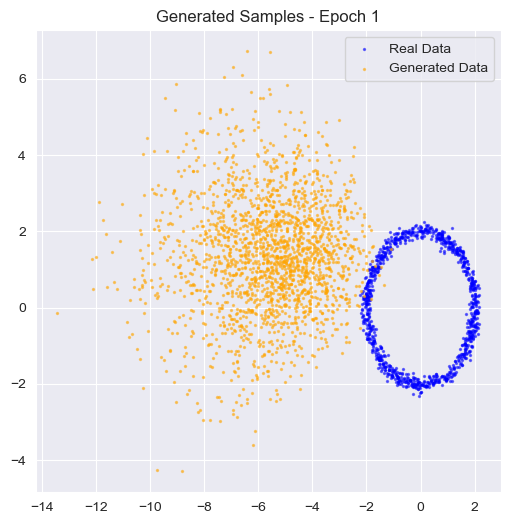

100%|██████████| 7/7 [00:00<00:00, 83.32it/s]


Epoch 2/50 | D Loss: 0.0000 | G Loss: 0.0005 | MI: -0.0320


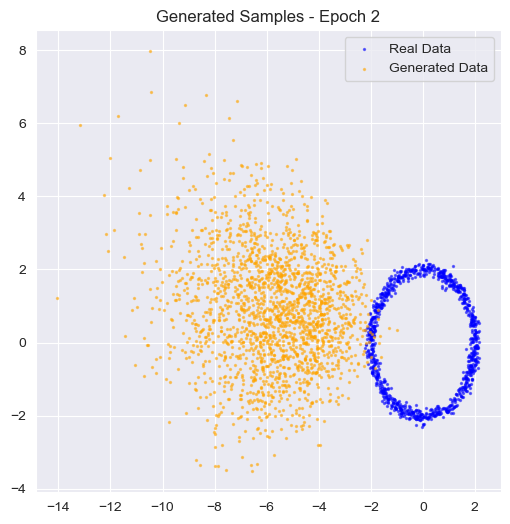

100%|██████████| 7/7 [00:00<00:00, 93.81it/s]


Epoch 3/50 | D Loss: 0.0000 | G Loss: -0.0037 | MI: 0.4042


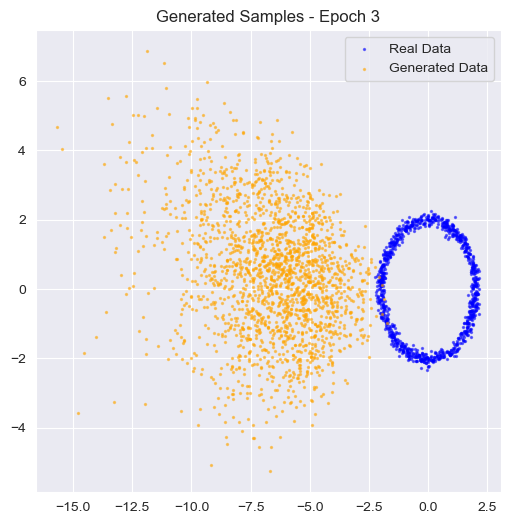

100%|██████████| 7/7 [00:00<00:00, 94.20it/s]


Epoch 4/50 | D Loss: 0.0000 | G Loss: -0.0054 | MI: 0.4737


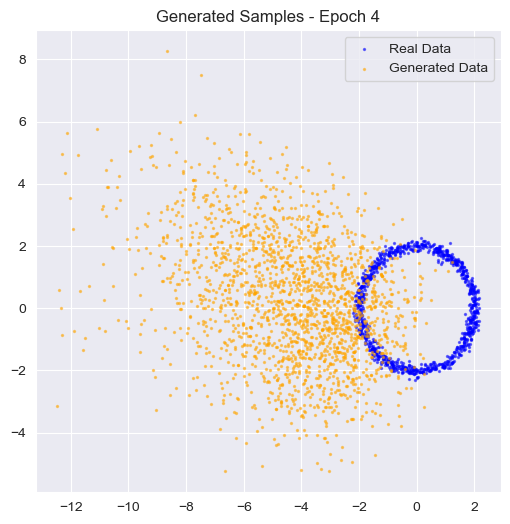

100%|██████████| 7/7 [00:00<00:00, 94.01it/s]


Epoch 5/50 | D Loss: 0.0006 | G Loss: -0.0056 | MI: 0.6169


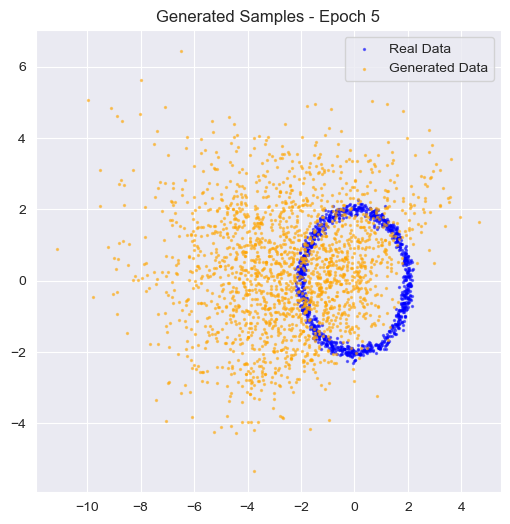

100%|██████████| 7/7 [00:00<00:00, 92.91it/s]


Epoch 6/50 | D Loss: 0.0005 | G Loss: -0.0050 | MI: 0.4107


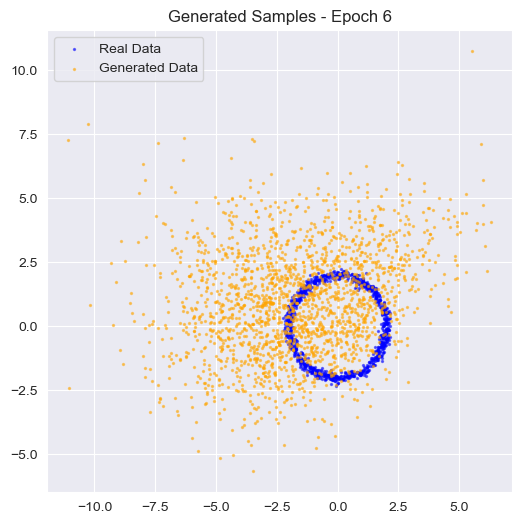

100%|██████████| 7/7 [00:00<00:00, 87.73it/s]


Epoch 7/50 | D Loss: 0.0002 | G Loss: -0.0094 | MI: 0.8367


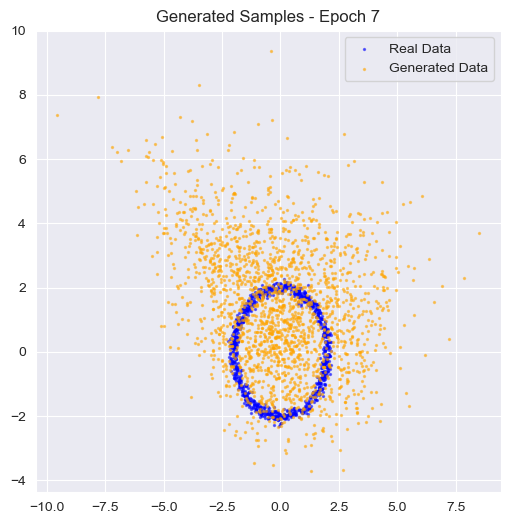

100%|██████████| 7/7 [00:00<00:00, 91.52it/s]


Epoch 8/50 | D Loss: 0.0001 | G Loss: -0.0072 | MI: 0.6702


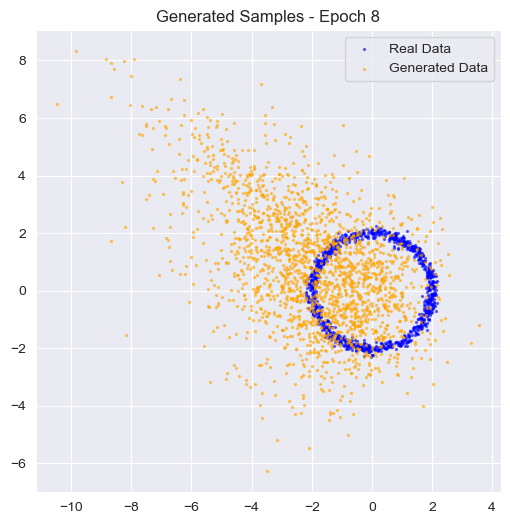

100%|██████████| 7/7 [00:00<00:00, 96.13it/s]


Epoch 9/50 | D Loss: 0.0001 | G Loss: -0.0094 | MI: 1.0276


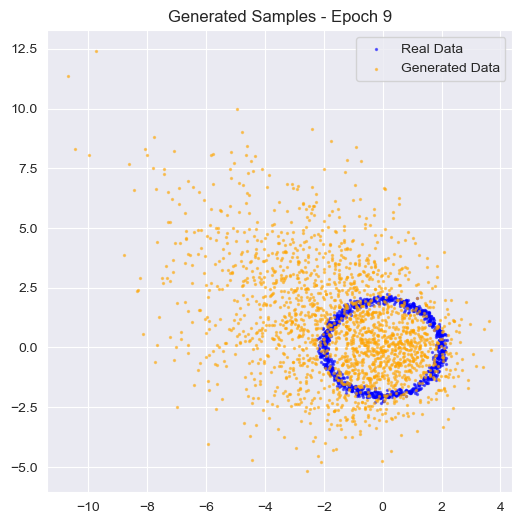

100%|██████████| 7/7 [00:00<00:00, 96.81it/s]


Epoch 10/50 | D Loss: 0.0000 | G Loss: -0.0147 | MI: 1.3548


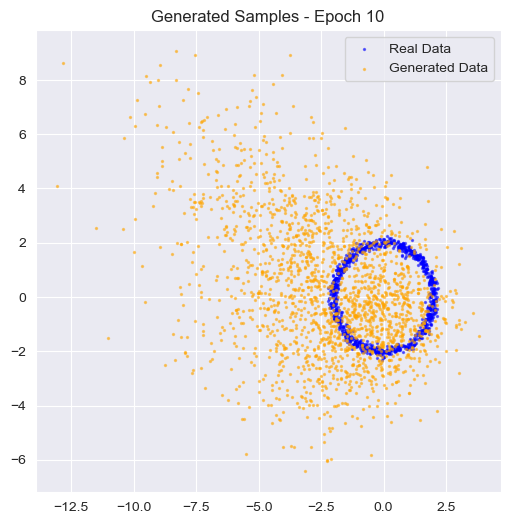

100%|██████████| 7/7 [00:00<00:00, 98.64it/s]


Epoch 11/50 | D Loss: 0.0000 | G Loss: -0.0173 | MI: 1.5779


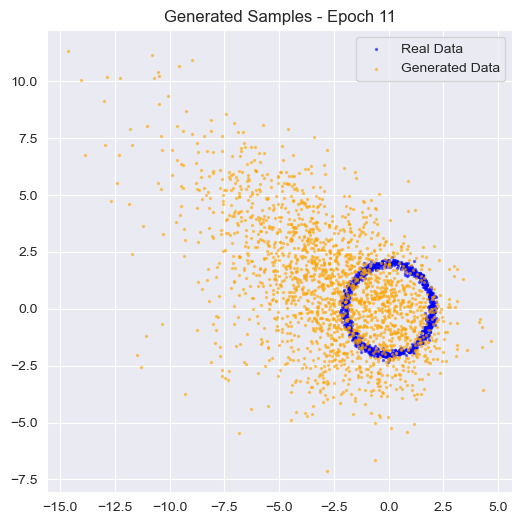

100%|██████████| 7/7 [00:00<00:00, 98.43it/s]


Epoch 12/50 | D Loss: 0.0000 | G Loss: -0.0185 | MI: 1.9688


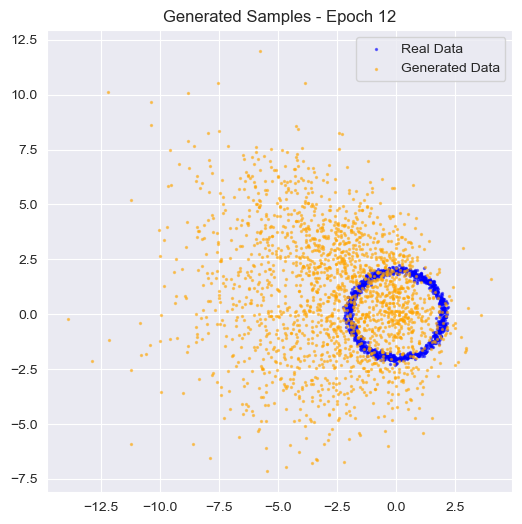

100%|██████████| 7/7 [00:00<00:00, 98.87it/s]


Epoch 13/50 | D Loss: 0.0000 | G Loss: -0.0176 | MI: 1.6381


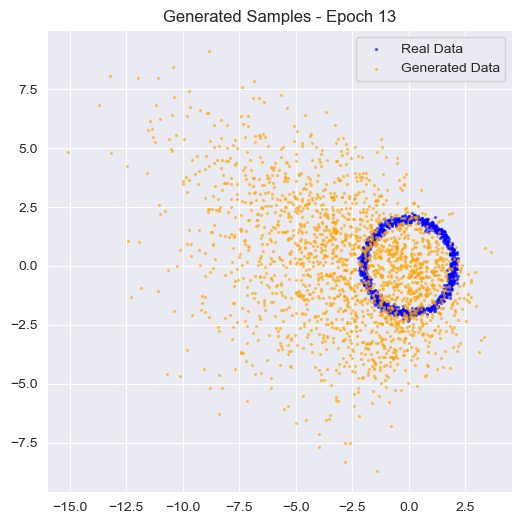

100%|██████████| 7/7 [00:00<00:00, 97.71it/s]


Epoch 14/50 | D Loss: 0.0000 | G Loss: -0.0198 | MI: 1.9759


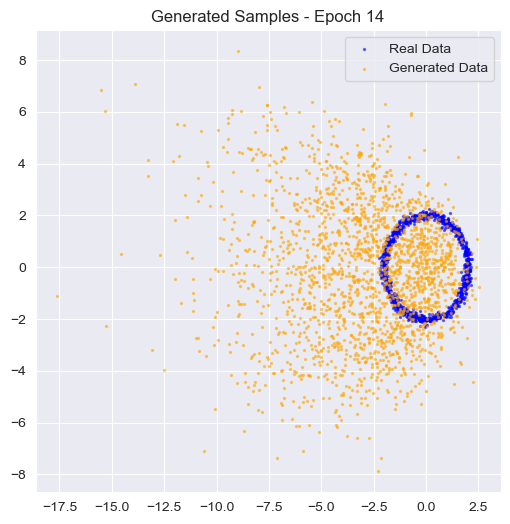

100%|██████████| 7/7 [00:00<00:00, 97.71it/s]


Epoch 15/50 | D Loss: 0.0000 | G Loss: -0.0103 | MI: 1.2826


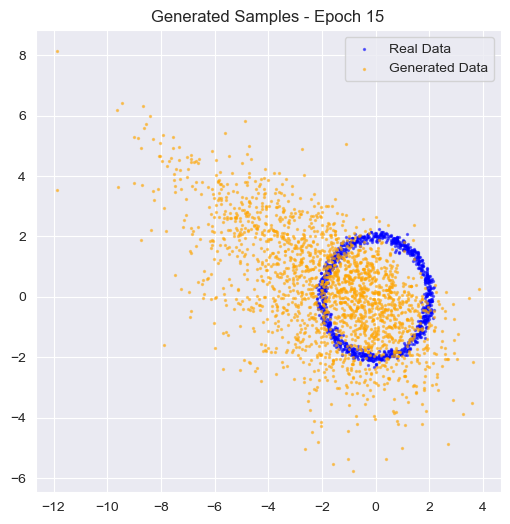

100%|██████████| 7/7 [00:00<00:00, 96.12it/s]


Epoch 16/50 | D Loss: 0.0000 | G Loss: -0.0100 | MI: 1.6410


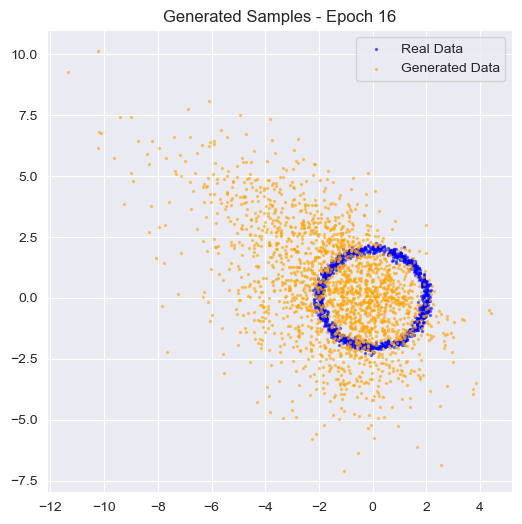

100%|██████████| 7/7 [00:00<00:00, 96.28it/s]


Epoch 17/50 | D Loss: 0.0000 | G Loss: -0.0197 | MI: 2.0479


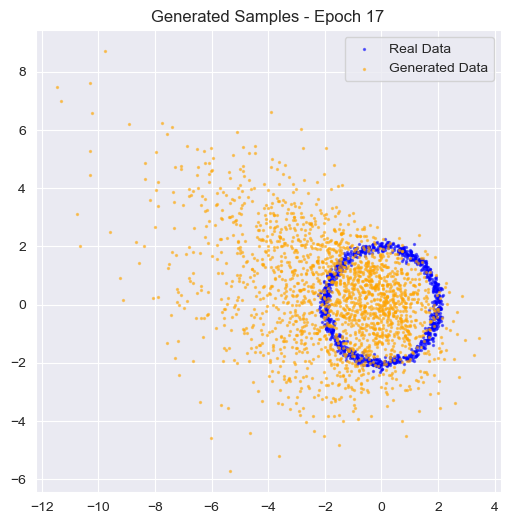

100%|██████████| 7/7 [00:00<00:00, 91.18it/s]


Epoch 18/50 | D Loss: 0.0000 | G Loss: -0.0218 | MI: 2.5319


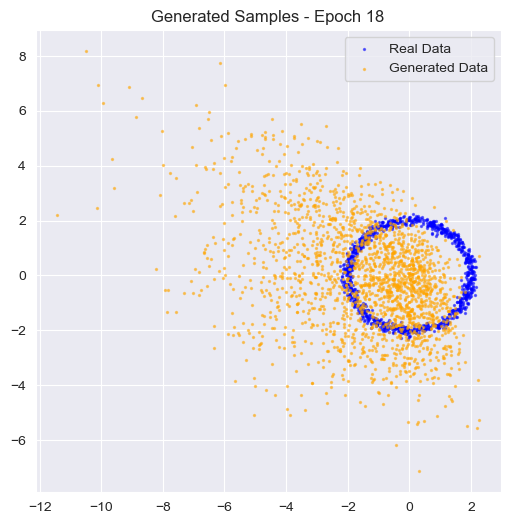

100%|██████████| 7/7 [00:00<00:00, 97.84it/s]


Epoch 19/50 | D Loss: 0.0000 | G Loss: -0.0173 | MI: 1.9657


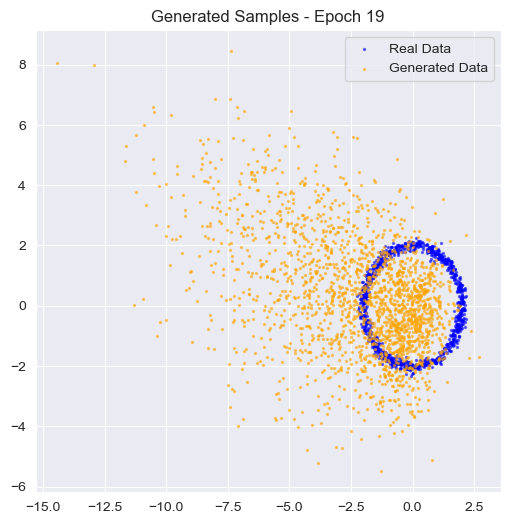

100%|██████████| 7/7 [00:00<00:00, 97.32it/s]


Epoch 20/50 | D Loss: 0.0000 | G Loss: -0.0200 | MI: 2.4269


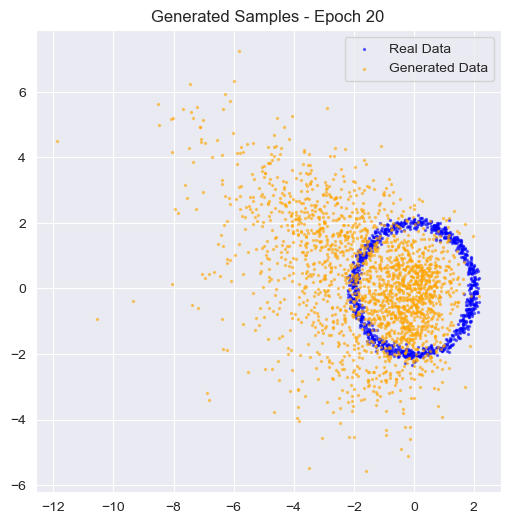

100%|██████████| 7/7 [00:00<00:00, 95.94it/s]


Epoch 21/50 | D Loss: 0.0000 | G Loss: -0.0233 | MI: 2.0119


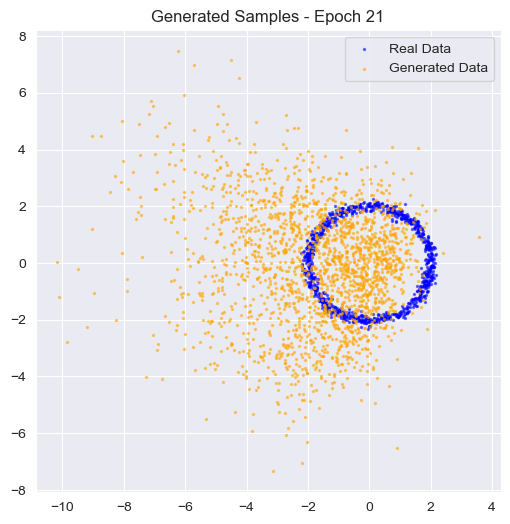

100%|██████████| 7/7 [00:00<00:00, 96.29it/s]


Epoch 22/50 | D Loss: 0.0000 | G Loss: -0.0148 | MI: 1.8126


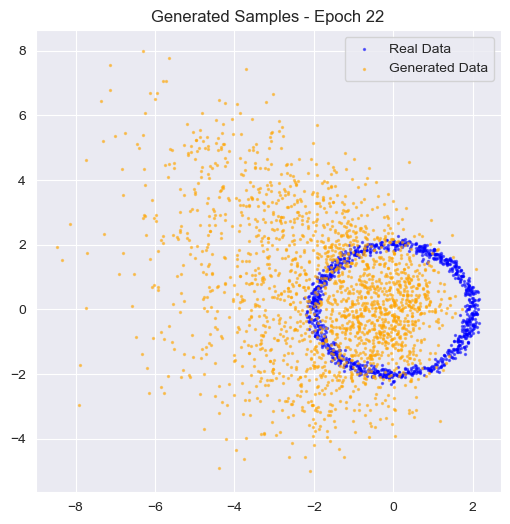

100%|██████████| 7/7 [00:00<00:00, 97.16it/s]


Epoch 23/50 | D Loss: 0.0000 | G Loss: -0.0215 | MI: 2.2646


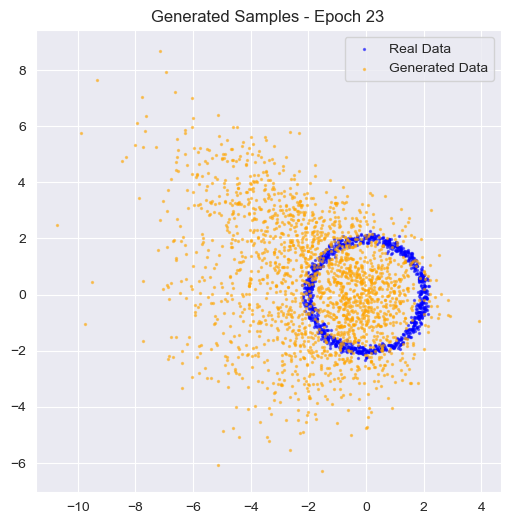

100%|██████████| 7/7 [00:00<00:00, 96.48it/s]


Epoch 24/50 | D Loss: 0.0000 | G Loss: -0.0311 | MI: 2.6754


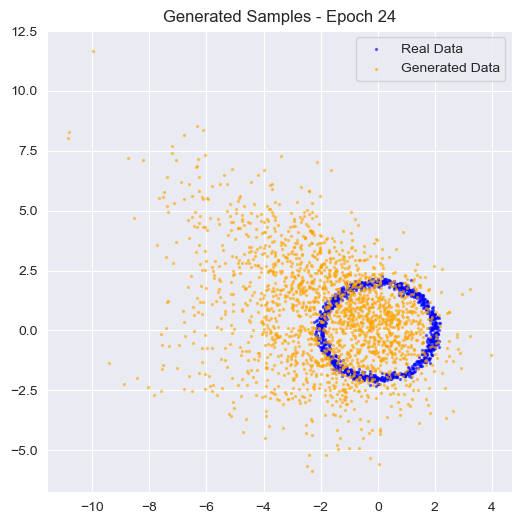

100%|██████████| 7/7 [00:00<00:00, 98.52it/s]


Epoch 25/50 | D Loss: 0.0000 | G Loss: -0.0278 | MI: 2.8200


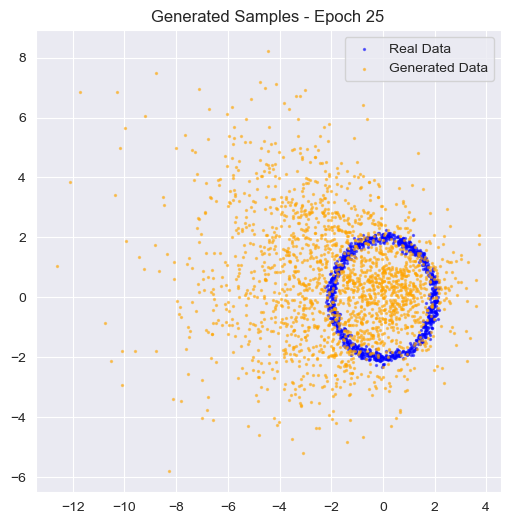

100%|██████████| 7/7 [00:00<00:00, 95.79it/s]


Epoch 26/50 | D Loss: 0.0000 | G Loss: -0.0258 | MI: 2.5827


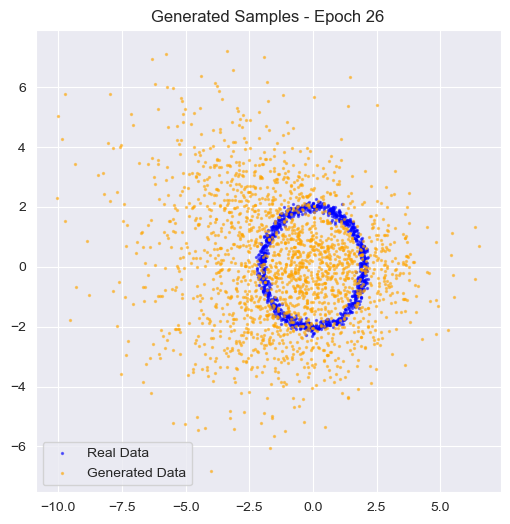

100%|██████████| 7/7 [00:00<00:00, 96.64it/s]


Epoch 27/50 | D Loss: 0.0000 | G Loss: -0.0208 | MI: 1.6579


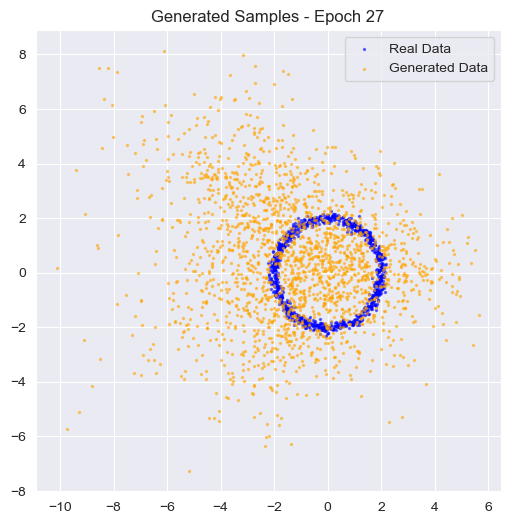

100%|██████████| 7/7 [00:00<00:00, 94.30it/s]


Epoch 28/50 | D Loss: 0.0000 | G Loss: -0.0258 | MI: 2.4117


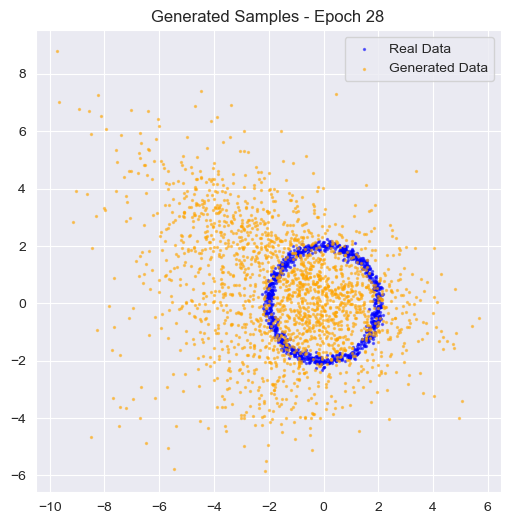

100%|██████████| 7/7 [00:00<00:00, 96.59it/s]


Epoch 29/50 | D Loss: 0.0000 | G Loss: -0.0242 | MI: 2.8506


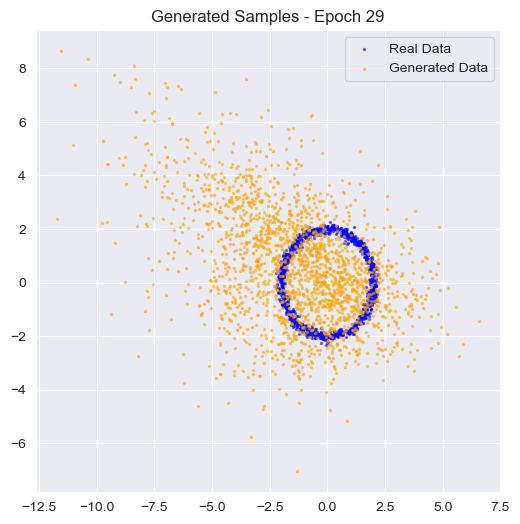

100%|██████████| 7/7 [00:00<00:00, 96.15it/s]


Epoch 30/50 | D Loss: 0.0000 | G Loss: -0.0331 | MI: 3.5619


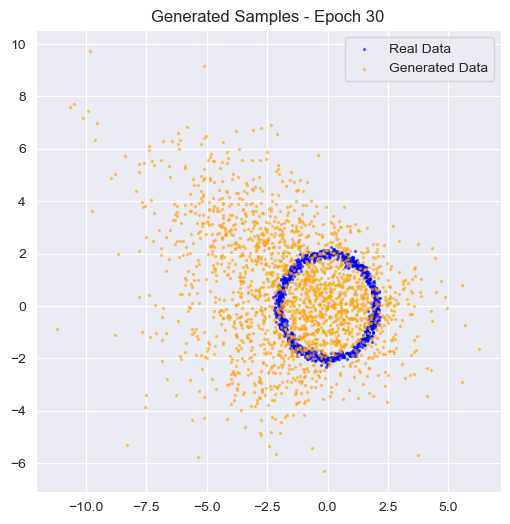

100%|██████████| 7/7 [00:00<00:00, 95.53it/s]


Epoch 31/50 | D Loss: 0.0000 | G Loss: -0.0300 | MI: 3.1957


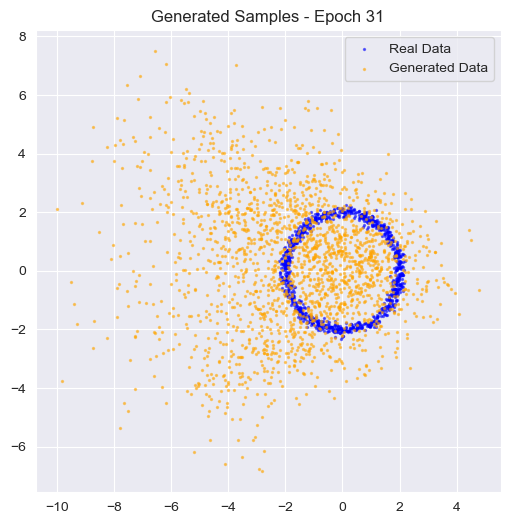

100%|██████████| 7/7 [00:00<00:00, 98.75it/s]


Epoch 32/50 | D Loss: 0.0000 | G Loss: -0.0331 | MI: 2.7994


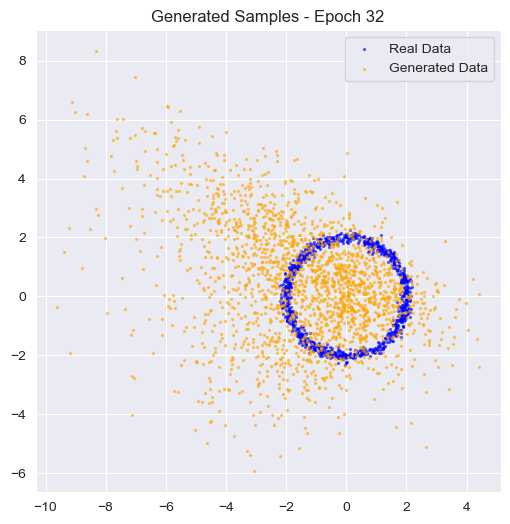

100%|██████████| 7/7 [00:00<00:00, 98.34it/s]


Epoch 33/50 | D Loss: 0.0000 | G Loss: -0.0338 | MI: 3.4855


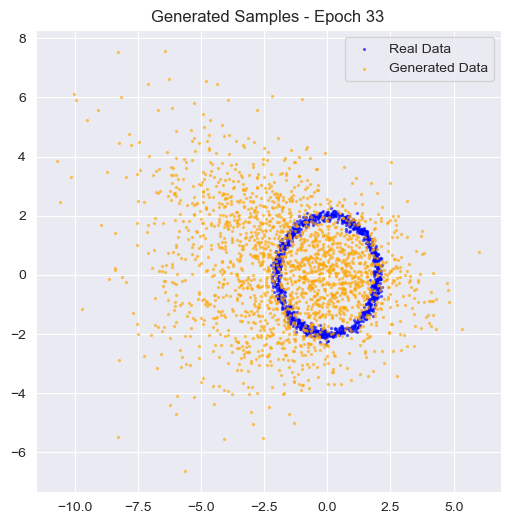

100%|██████████| 7/7 [00:00<00:00, 98.72it/s]


Epoch 34/50 | D Loss: 0.0000 | G Loss: -0.0352 | MI: 3.6074


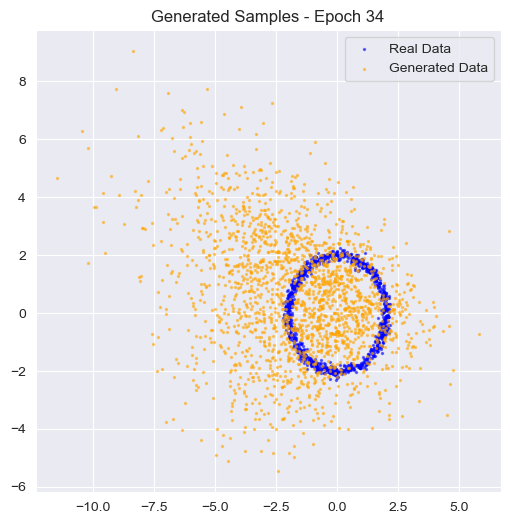

100%|██████████| 7/7 [00:00<00:00, 94.30it/s]


Epoch 35/50 | D Loss: 0.0000 | G Loss: -0.0367 | MI: 3.6507


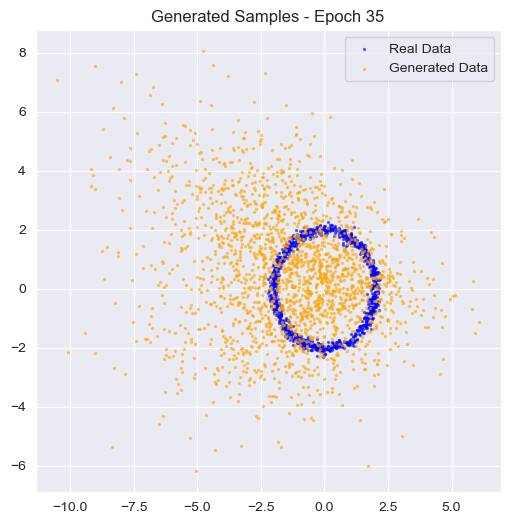

100%|██████████| 7/7 [00:00<00:00, 96.40it/s]


Epoch 36/50 | D Loss: 0.0000 | G Loss: -0.0317 | MI: 3.7087


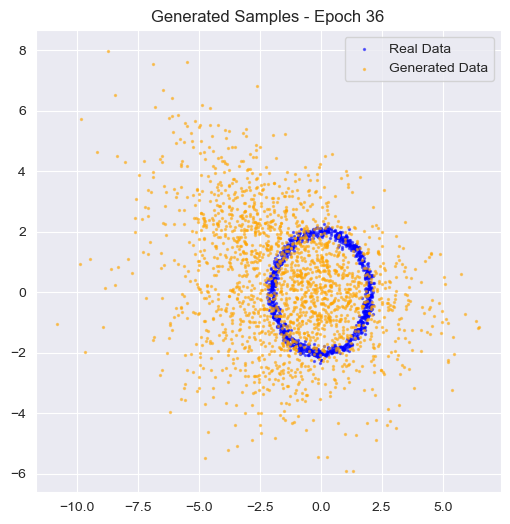

100%|██████████| 7/7 [00:00<00:00, 97.51it/s]


Epoch 37/50 | D Loss: 0.0000 | G Loss: -0.0405 | MI: 3.9835


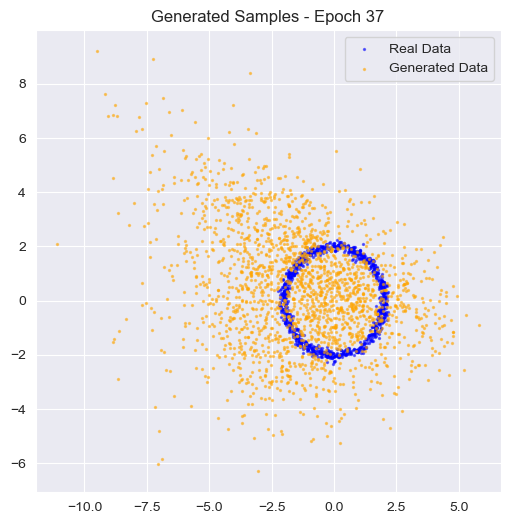

100%|██████████| 7/7 [00:00<00:00, 97.42it/s]


Epoch 38/50 | D Loss: 0.0000 | G Loss: -0.0389 | MI: 3.9562


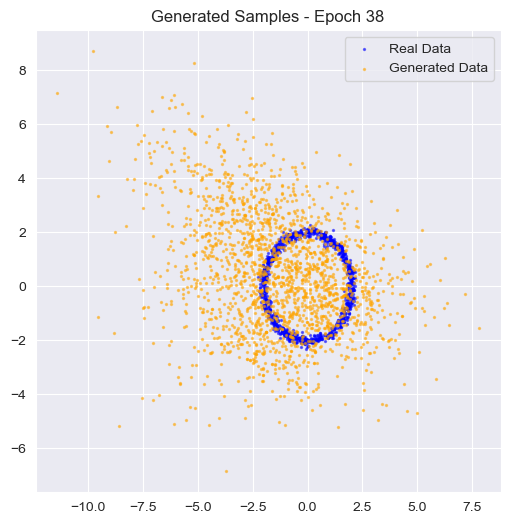

100%|██████████| 7/7 [00:00<00:00, 94.70it/s]


Epoch 39/50 | D Loss: 0.0000 | G Loss: -0.0450 | MI: 3.9672


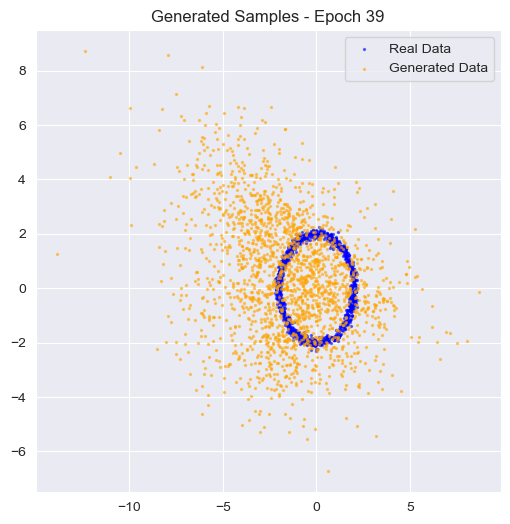

100%|██████████| 7/7 [00:00<00:00, 97.38it/s]


Epoch 40/50 | D Loss: 0.0000 | G Loss: -0.0396 | MI: 3.4091


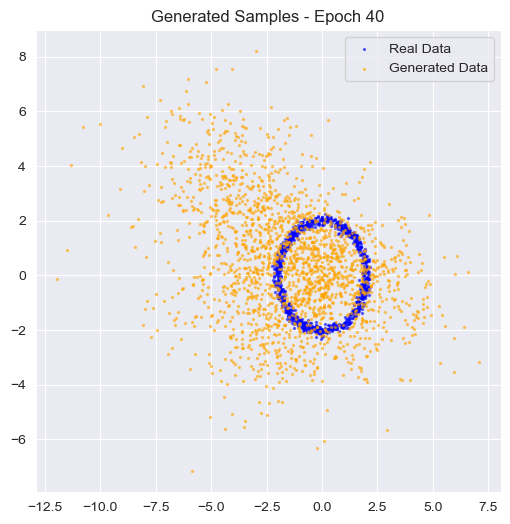

100%|██████████| 7/7 [00:00<00:00, 98.39it/s]


Epoch 41/50 | D Loss: 0.0000 | G Loss: -0.0417 | MI: 3.9614


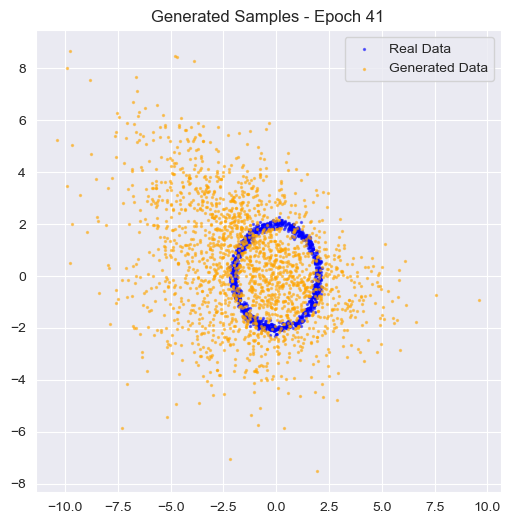

100%|██████████| 7/7 [00:00<00:00, 94.22it/s]


Epoch 42/50 | D Loss: 0.0000 | G Loss: -0.0459 | MI: 3.9408


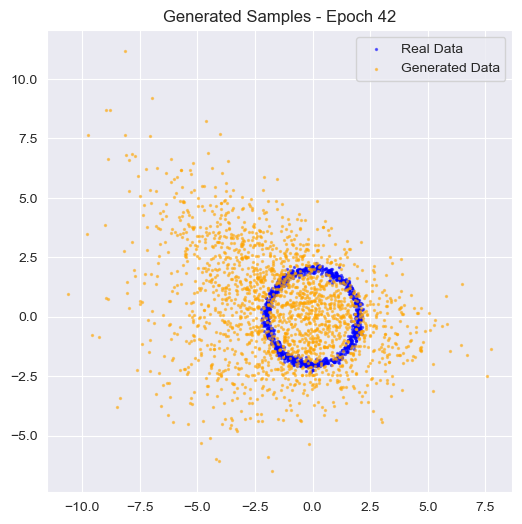

100%|██████████| 7/7 [00:00<00:00, 96.76it/s]


Epoch 43/50 | D Loss: 0.0000 | G Loss: -0.0348 | MI: 4.9233


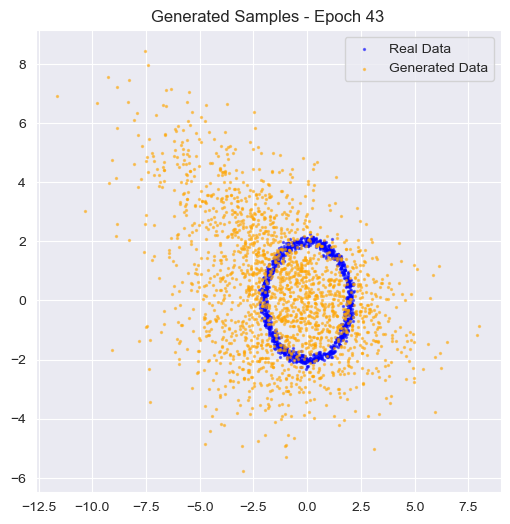

100%|██████████| 7/7 [00:00<00:00, 97.95it/s]


Epoch 44/50 | D Loss: 0.0000 | G Loss: -0.0457 | MI: 4.1247


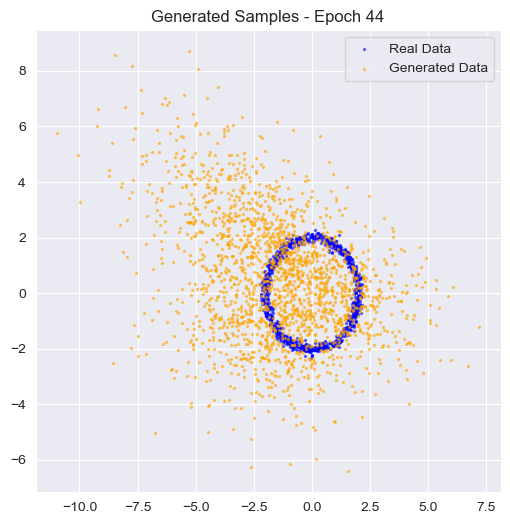

100%|██████████| 7/7 [00:00<00:00, 97.12it/s]


Epoch 45/50 | D Loss: 0.0000 | G Loss: -0.0430 | MI: 4.3800


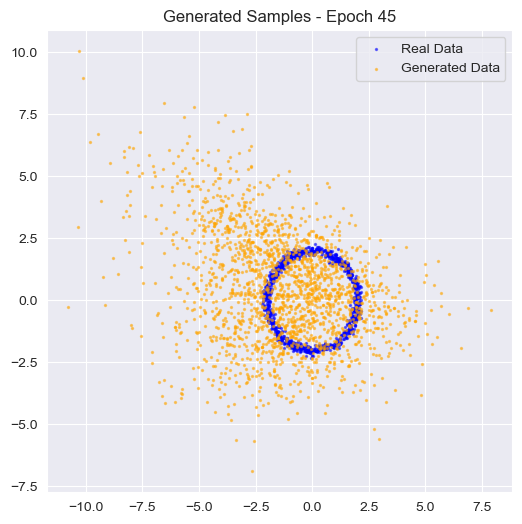

100%|██████████| 7/7 [00:00<00:00, 95.80it/s]


Epoch 46/50 | D Loss: 0.0000 | G Loss: -0.0374 | MI: 4.5543


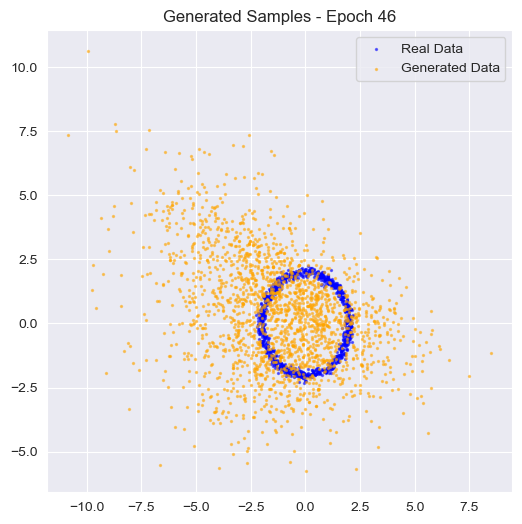

100%|██████████| 7/7 [00:00<00:00, 96.89it/s]


Epoch 47/50 | D Loss: 0.0000 | G Loss: -0.0399 | MI: 5.1421


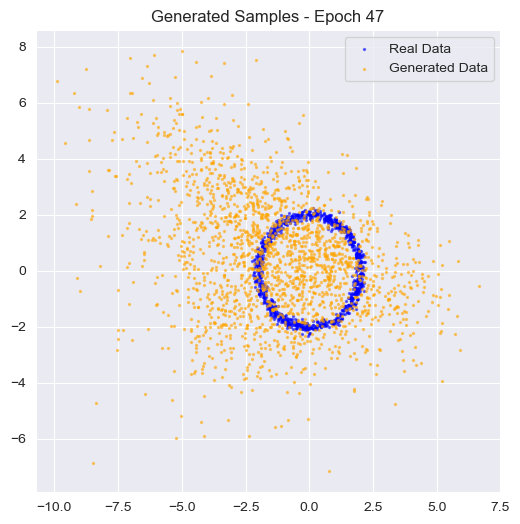

100%|██████████| 7/7 [00:00<00:00, 95.67it/s]


Epoch 48/50 | D Loss: 0.0000 | G Loss: -0.0411 | MI: 4.5705


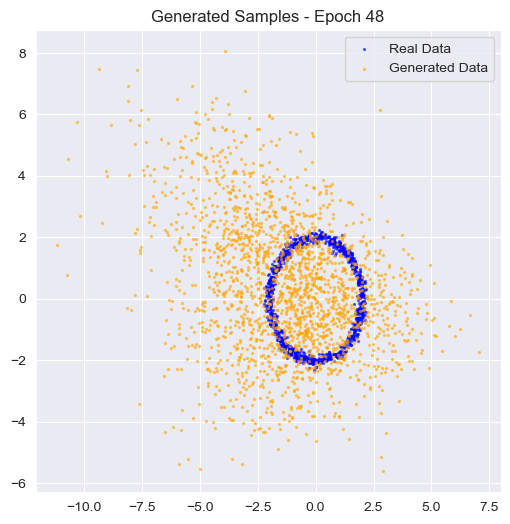

100%|██████████| 7/7 [00:00<00:00, 94.78it/s]


Epoch 49/50 | D Loss: 0.0000 | G Loss: -0.0412 | MI: 4.1953


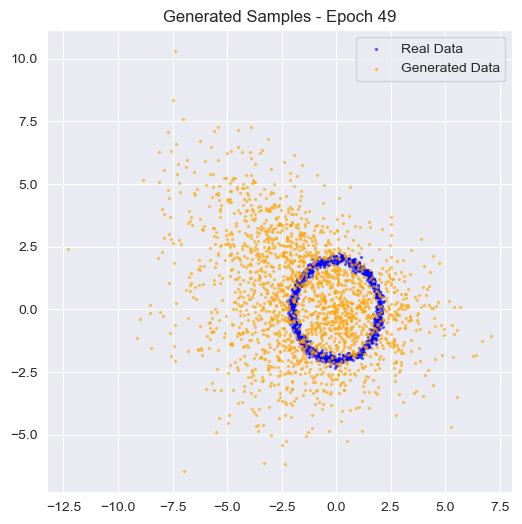

100%|██████████| 7/7 [00:00<00:00, 95.06it/s]


Epoch 50/50 | D Loss: 0.0000 | G Loss: -0.0492 | MI: 4.8494


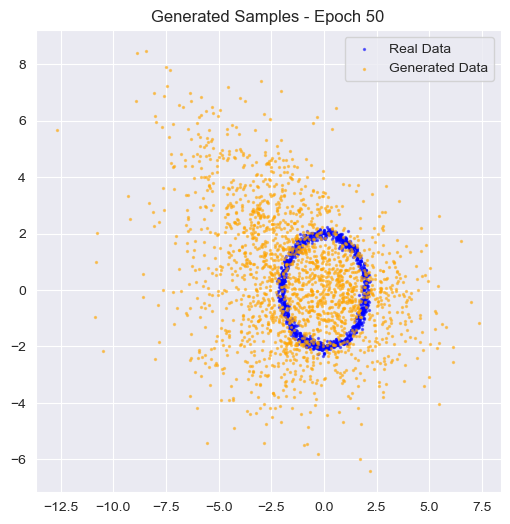

In [957]:
train(
    G=generator,
    D=discriminator,
    M=mine_net,
    g_optimizer=g_optimizer,
    d_optimizer=d_optimizer,
    m_optimizer=m_optimizer,
    real_data=circle_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    mi_lambda=MI_LAMBDA,
    clipping_factor=0.01
)